# Image classification with Convolutional Neural Networks - Game of Thrones Style

Read the blog on notebook and to get additional details at my medium page: [@HariniLabs](https://medium.com/@harinilabs)

## Code: 'Drogon Vs Viserion'

## Libraries

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data

In [2]:
PATH = "data/drogonviserion/"
sz=224

## Verify Data

In [3]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [4]:
files = os.listdir(f'{PATH}train/drogon')[:5]
files

['drogon2.png', 'drogon6.jpeg', 'drogon4.jpg', 'drogon3.jpg', 'drogon5.jpg']

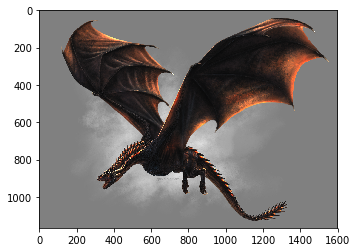

In [5]:
img = plt.imread(f'{PATH}train/drogon/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [6]:
img.shape

(1167, 1600, 3)

In [7]:
img[:4,:4]

array([[[ 0.58039,  0.58039,  0.58039],
        [ 0.53725,  0.53725,  0.53725],
        [ 0.54118,  0.54118,  0.54118],
        [ 0.54118,  0.54118,  0.54118]],

       [[ 0.52157,  0.52157,  0.52157],
        [ 0.50196,  0.50196,  0.50196],
        [ 0.50196,  0.50196,  0.50196],
        [ 0.50196,  0.50196,  0.50196]],

       [[ 0.54118,  0.54118,  0.54118],
        [ 0.50196,  0.50196,  0.50196],
        [ 0.50196,  0.50196,  0.50196],
        [ 0.50196,  0.50196,  0.50196]],

       [[ 0.54118,  0.54118,  0.54118],
        [ 0.50196,  0.50196,  0.50196],
        [ 0.50196,  0.50196,  0.50196],
        [ 0.50196,  0.50196,  0.50196]]], dtype=float32)

## Build Image Classifier CNN Model

Here's how to train and evalulate a *drogon vs viserion* model in 3 lines of code, and under 20 seconds:

In [8]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01,3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.895668   0.802099   0.625     
    1      1.02754    0.538006   0.75            
    2      0.853791   0.350951   0.875           



[array([ 0.35095]), 0.875]

## Results Analysis

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. The most correct labels of each class (i.e. those with highest probability that are correct)
3. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
4. The most uncertain labels (i.e. those with probability closest to 0.5).

In [9]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 1, 1, 1, 1])

In [10]:
# from here we know that 'drogon' is label 0 and 'viserion' is label 1.
data.classes

['drogon', 'viserion']

In [11]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(8, 2)

In [12]:
log_preds[:10]

array([[-0.25069, -1.50628],
       [-1.05914, -0.4258 ],
       [-0.1119 , -2.24558],
       [-0.47879, -0.96635],
       [-1.55914, -0.23612],
       [-1.63226, -0.21752],
       [-1.3611 , -0.29622],
       [-1.92769, -0.15722]], dtype=float32)

In [13]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [14]:
# Method definitions to plot results
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly classified


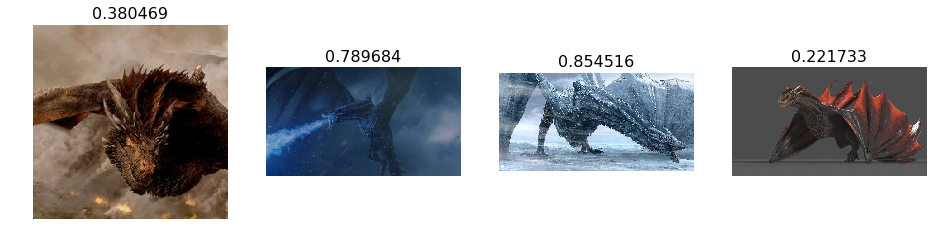

In [15]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Most correct drogon


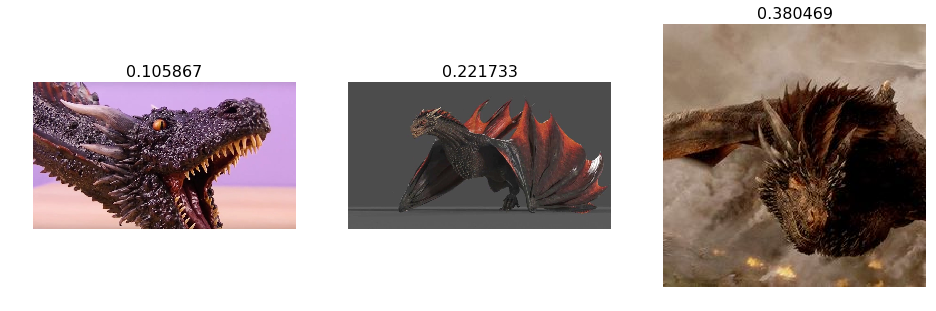

In [16]:
plot_val_with_title(most_by_correct(0, True), "Most correct drogon")

Most correct viserion


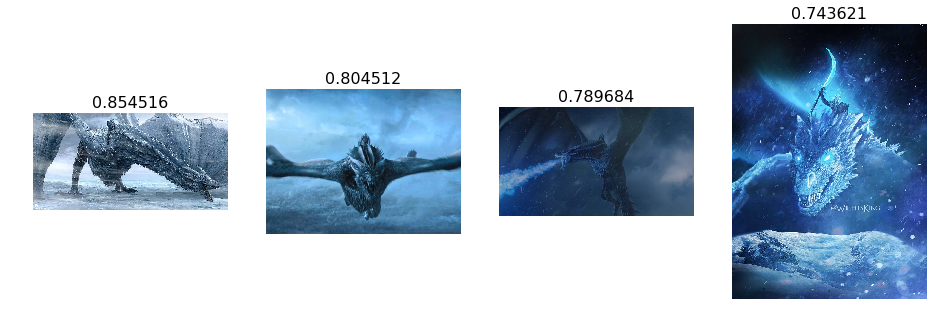

In [17]:
plot_val_with_title(most_by_correct(1, True), "Most correct viserion")

Most uncertain predictions


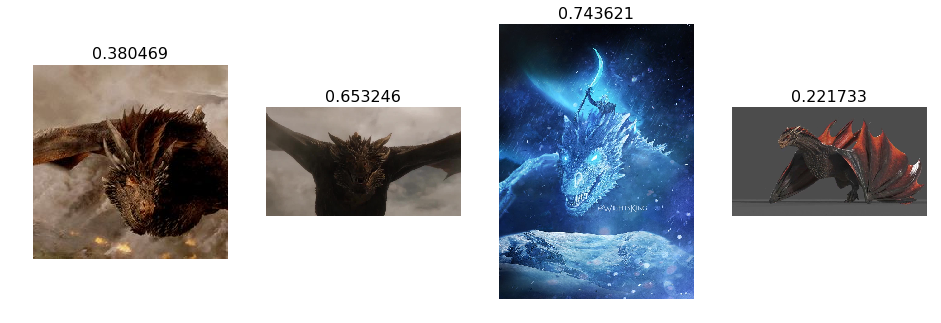

In [18]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")